In [106]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from src.graficar import graficar_serie 
from src.ARIMA_experimento import ARIMA_experimento
from src.evaluar import evaluar_forecast

###  Descomposición de la serie ###
from statsmodels.tsa.seasonal import seasonal_decompose

## Reporte 1
* Ventana de 1000 muestras
* Horizonte de 500 muestras

In [107]:
variable = 'Valores'
ruta = 'data/clean_data/serie_1.csv'
s1 = pd.read_csv(ruta, index_col = 0)
print(f's1 shape: {s1.shape}')
s1.head()

s1 shape: (1500, 1)


,Valores
0,459.33
1,460.90
2,459.39
3,458.22
4,458.71


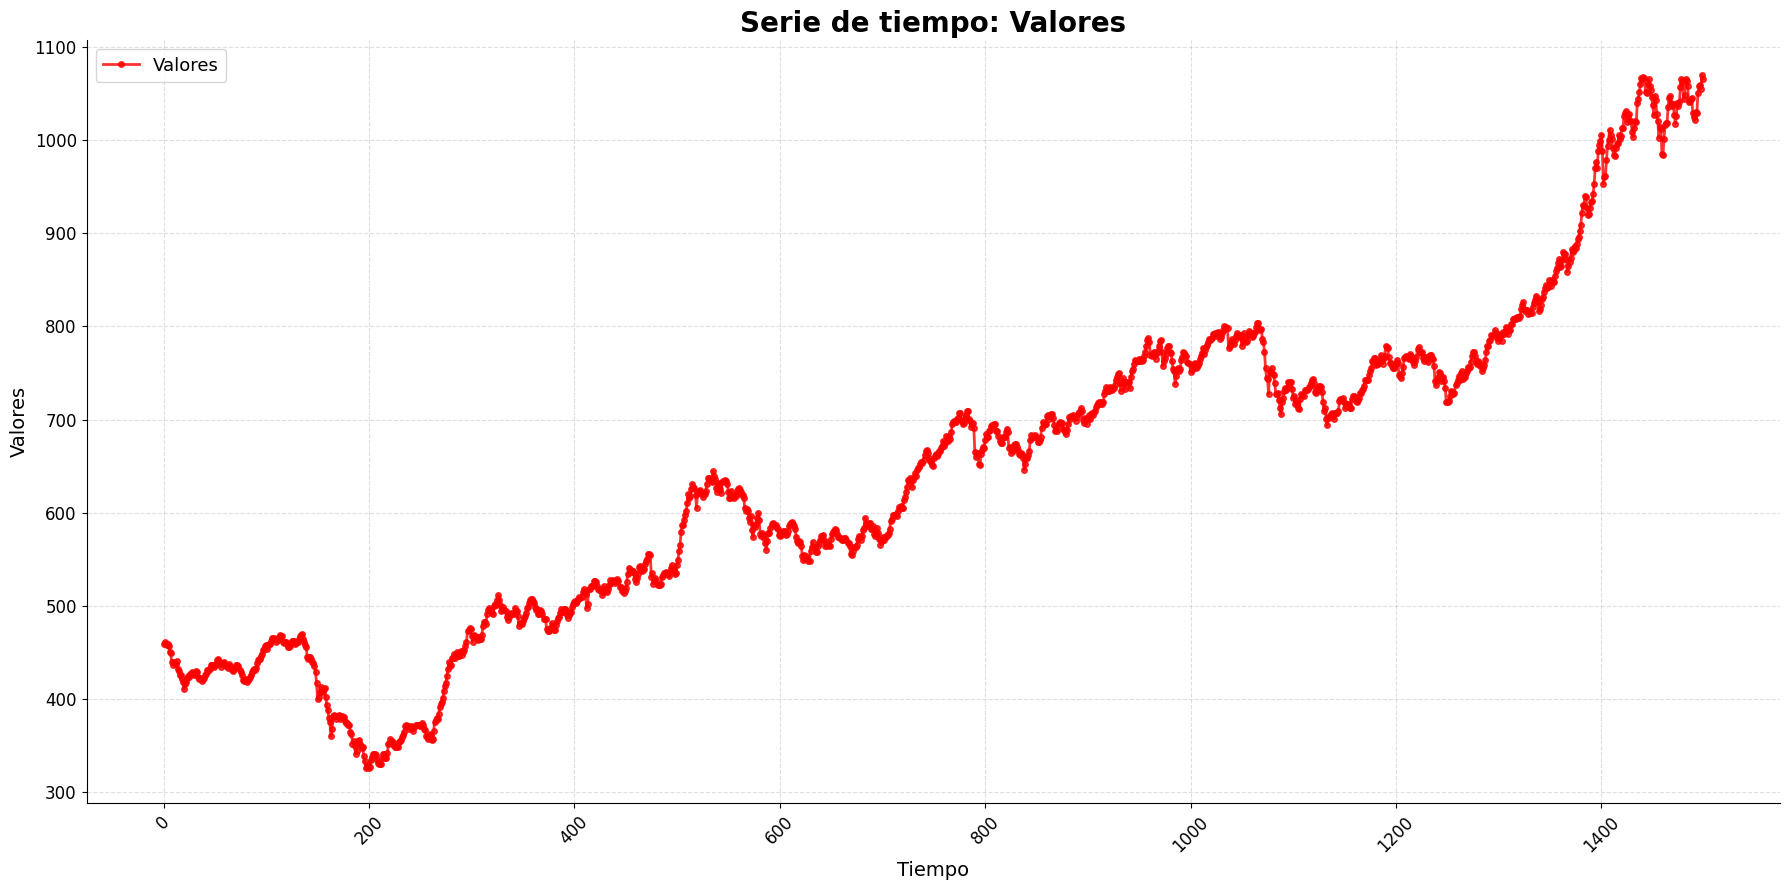

In [108]:
graficar_serie(s1, variable, color = 'red')

### Descomponer la serie

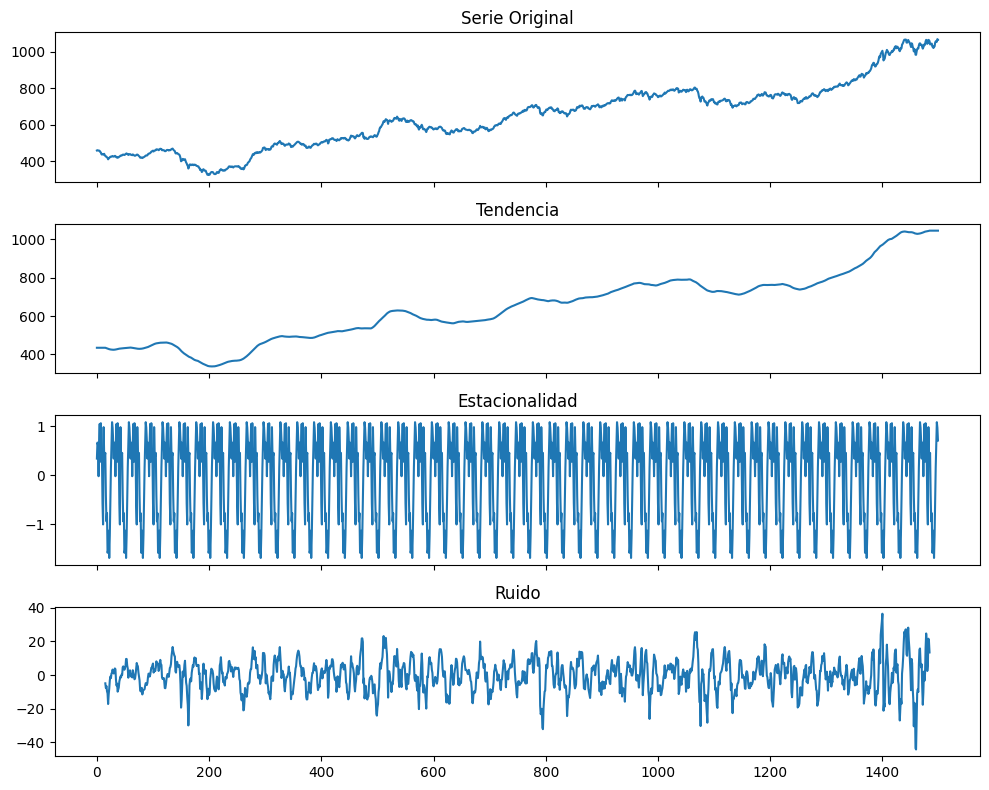

In [109]:
desc = seasonal_decompose(s1['Valores'], model = 'additive', period = 30)

# Definir descomposicion
tendencia = desc.trend
tendencia = tendencia.interpolate(method = 'linear', limit_direction = 'both')
estacionalidad = desc.seasonal
ruido = desc.resid

# Graficar la descomposición
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(10, 8), sharex=True)

s1['Valores'].plot(ax=ax1, title='Serie Original')
tendencia.plot(ax=ax2, title='Tendencia')
estacionalidad.plot(ax=ax3, title='Estacionalidad')
ruido.plot(ax=ax4, title='Ruido')

plt.tight_layout()
plt.show()
plt.close()

### Repartir la desocmposición para Ventana y Ruido

In [110]:
print(f'shape serie          : {s1.shape}')
print(f'shape tendencia      : {tendencia.shape}')
print(f'shape estacionalidad : {estacionalidad.shape}')
print(f'shape ruido          : {ruido.shape}')

shape serie          : (1500, 1)
shape tendencia      : (1500,)
shape estacionalidad : (1500,)
shape ruido          : (1500,)


In [111]:
ventana = s1[:1000].squeeze()
horizonte = s1[1000:].squeeze()

tendencia_v = tendencia[:1000]
tendencia_h = tendencia[1000:]
estacionalidad_v = estacionalidad[:1000]
estacionalidad_h = estacionalidad[1000:]
ruido_v = ruido[:1000]
ruido_h = ruido[1000:]

print(f'shape ventana                  : {ventana.shape}')
print(f'shape horizonte                : {horizonte.shape}')
print('')
print(f'shape tendencia ventana        : {tendencia_v.shape}')
print(f'shape tendencia horizonte      : {tendencia_h.shape}')
print(f'shape estacionalidad ventana   : {estacionalidad_v.shape}')
print(f'shape estacionalidad horizonte : {estacionalidad_h.shape}')
print(f'shape ruido ventana            : {ruido_v.shape}')
print(f'shape ruido horizonte          : {ruido_h.shape}')

shape ventana                  : (1000,)
shape horizonte                : (500,)

shape tendencia ventana        : (1000,)
shape tendencia horizonte      : (500,)
shape estacionalidad ventana   : (1000,)
shape estacionalidad horizonte : (500,)
shape ruido ventana            : (1000,)
shape ruido horizonte          : (500,)


### Restar a la ventana su parte de tendencia

shape ventana   : (1000,)
shape tendencia : (1000,)
shape simple    : (1000, 1)


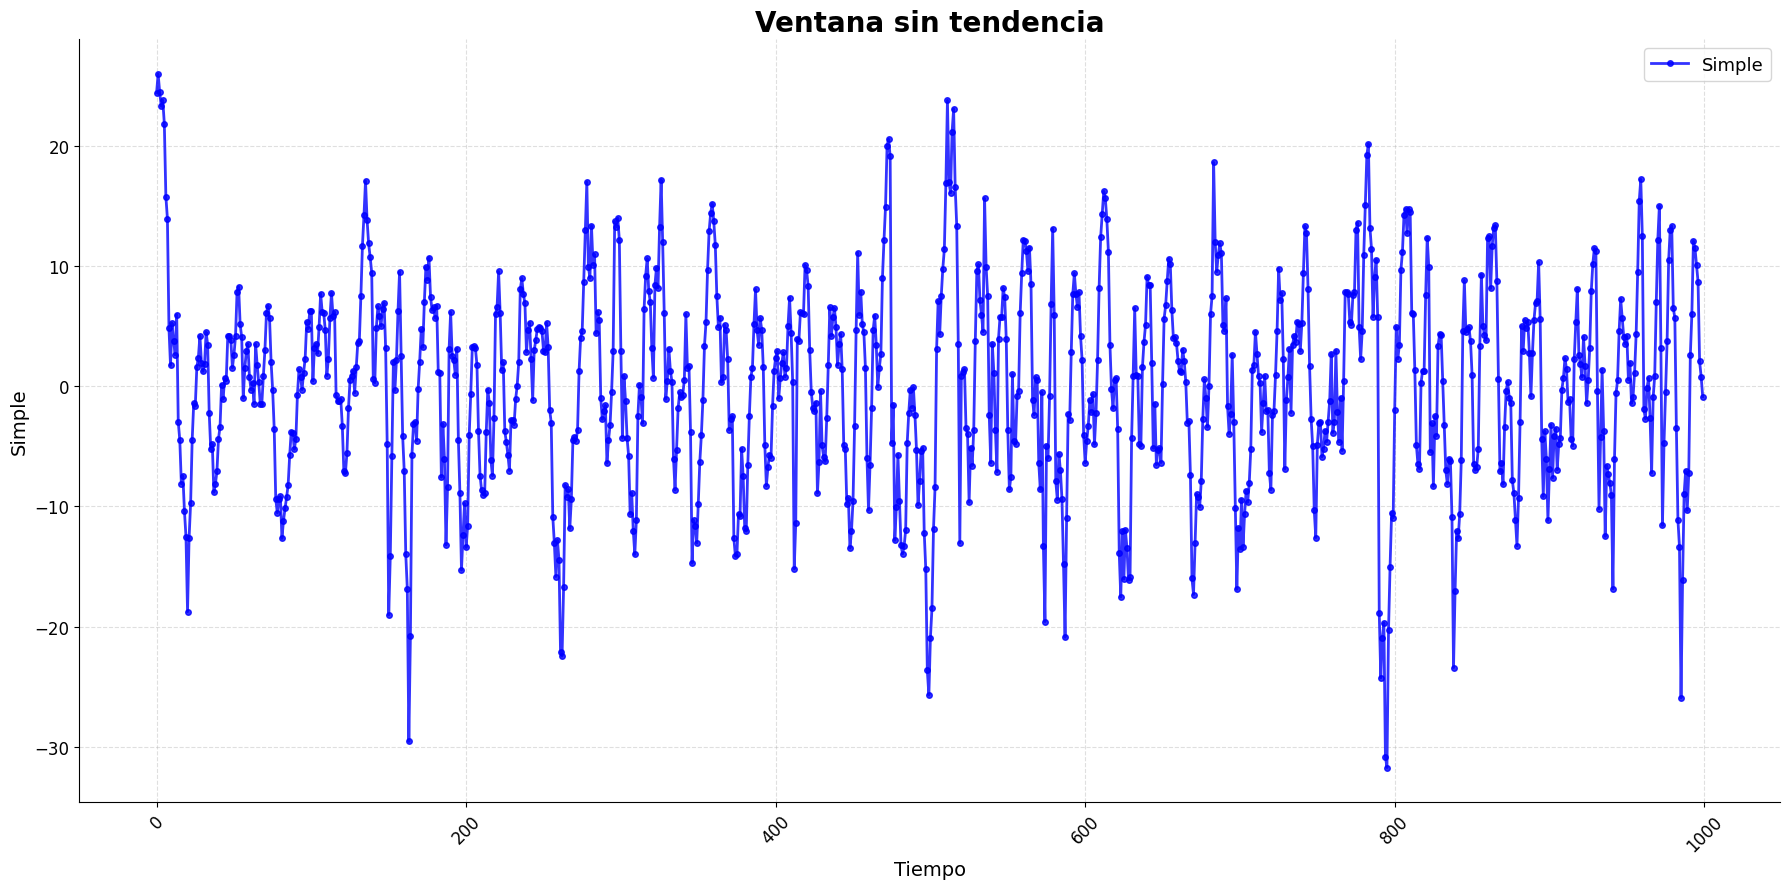

In [112]:
simple = ventana - tendencia_v
simple = pd.DataFrame(simple, columns = ['Simple'])
 
print(f'shape ventana   : {ventana.shape}')
print(f'shape tendencia : {tendencia_v.shape}')
print(f'shape simple    : {simple.shape}')
graficar_serie(simple, 'Simple', color = 'blue', titulo = 'Ventana sin tendencia')

### Experimento 1

/home/jair/anaconda3/envs/series_env/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



 Modelo ARIMA(5,2,5) entrenado exitosamente

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1000
Model:               SARIMAX(5, 2, 5)   Log Likelihood               -2880.168
Date:                Mon, 03 Nov 2025   AIC                           5782.336
Time:                        21:38:14   BIC                           5836.232
Sample:                             0   HQIC                          5802.828
                               - 1000                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.8384      2.553     -0.328      0.743      -5.842       4.165
ar.L2         -0.3653      2.432     -0.150      0.881      -5.131       4.401
ar.L3 

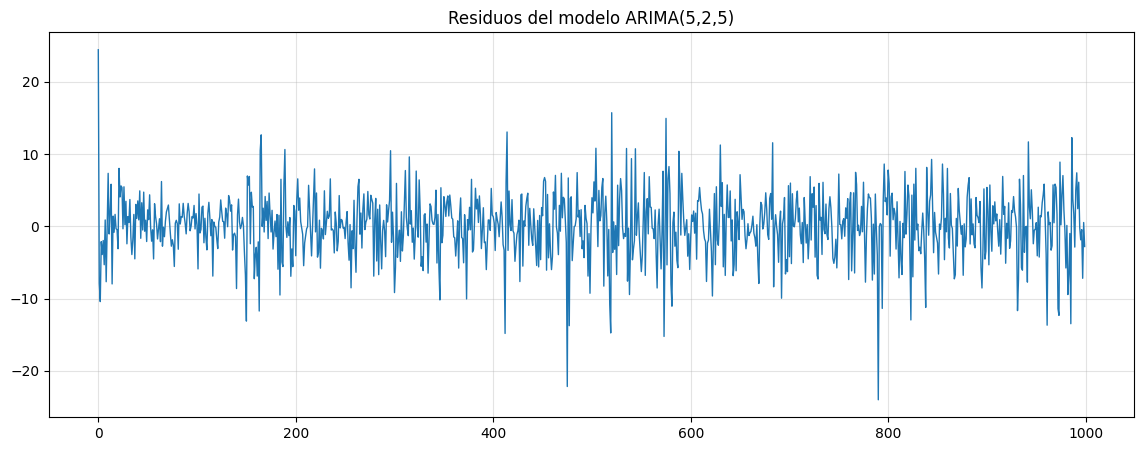

<Figure size 1400x400 with 0 Axes>

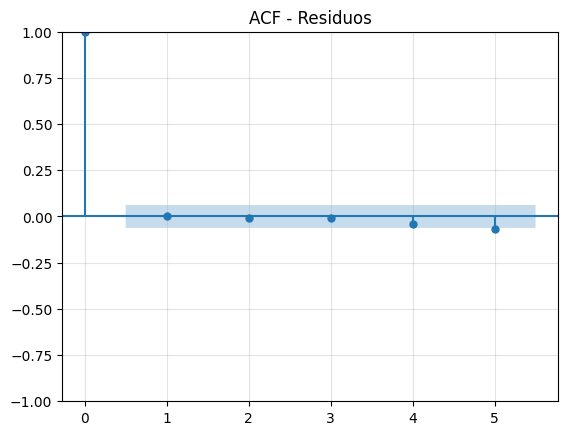

<Figure size 1400x400 with 0 Axes>

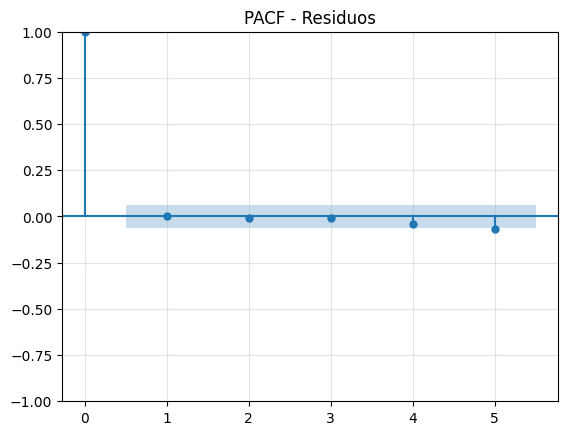


 Test de Ljung - Box ¿Es ruido blanco?

    lb_stat  lb_pvalue
1  0.002257   0.962109
2  0.067897   0.966621
3  0.174021   0.981670
4  1.740516   0.783345
5  6.485995   0.261757

 Interpretacion de la Hipótesis nula

Lag 1: No rechaza Ho -- Residuos se comportan como ruido blanco
Lag 2: No rechaza Ho -- Residuos se comportan como ruido blanco
Lag 3: No rechaza Ho -- Residuos se comportan como ruido blanco
Lag 4: No rechaza Ho -- Residuos se comportan como ruido blanco
Lag 5: No rechaza Ho -- Residuos se comportan como ruido blanco


In [113]:
serie = pd.Series(simple['Simple'].values, index=ventana.index)
p = 5
d = 2
q = 5
resultado, residuos = ARIMA_experimento(serie, p, d, q, 5)

### Forecast

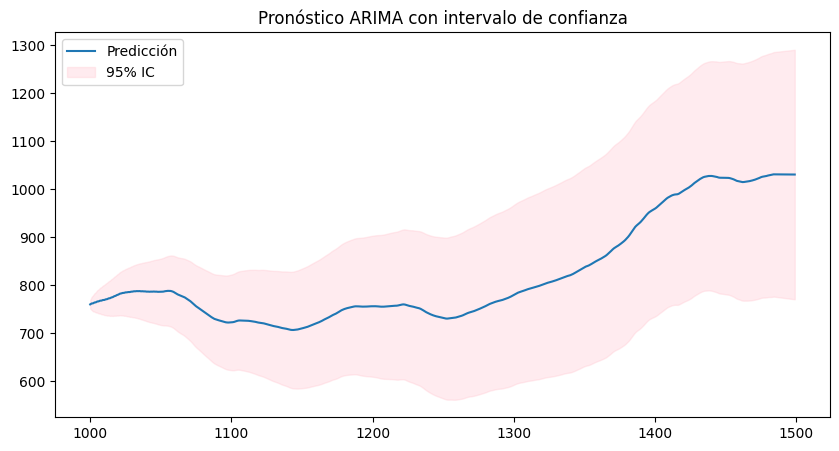

In [114]:
forecast_obj = resultado.get_forecast(steps=len(horizonte))

# Extraer la media predicha y alinear índices
forecast_std = forecast_obj.predicted_mean
forecast_std.index = horizonte.index

# Regresar el forecast a la escala de el horizonte
forecast_reescalado = forecast_std + tendencia_h

# Extraer intervalo de confianza directamente del objeto
intervalo = forecast_obj.conf_int(alpha=0.05)
intervalo.index = horizonte.index  # alinear índices con tu horizonte
intervalo = intervalo + tendencia_h.values.reshape(-1, 1)

# Graficar
plt.figure(figsize=(10,5))
plt.plot(forecast_reescalado, label='Predicción')
plt.fill_between(intervalo.index, intervalo.iloc[:, 0], intervalo.iloc[:, 1],
                 color='pink', alpha=0.3, label='95% IC')
plt.legend()
plt.title('Pronóstico ARIMA con intervalo de confianza')
plt.show()

### Evaluar Forecast

In [115]:
y_true = np.array(horizonte.values).flatten()
y_pred = np.array(forecast_reescalado).flatten()

print(f'shape Y_True : {y_true.shape}')
print(f'shape Y_Pred : {y_pred.shape}')

medidas = evaluar_forecast(y_true, y_pred)

for nombre, valor in medidas.items():
    print(f'{nombre} : {np.round(valor, 4)}')

shape Y_True : (500,)
shape Y_Pred : (500,)
RMSE : 13.9681
SMAPE : 1.2934
R2_Pearson : 0.9903


### Graficar

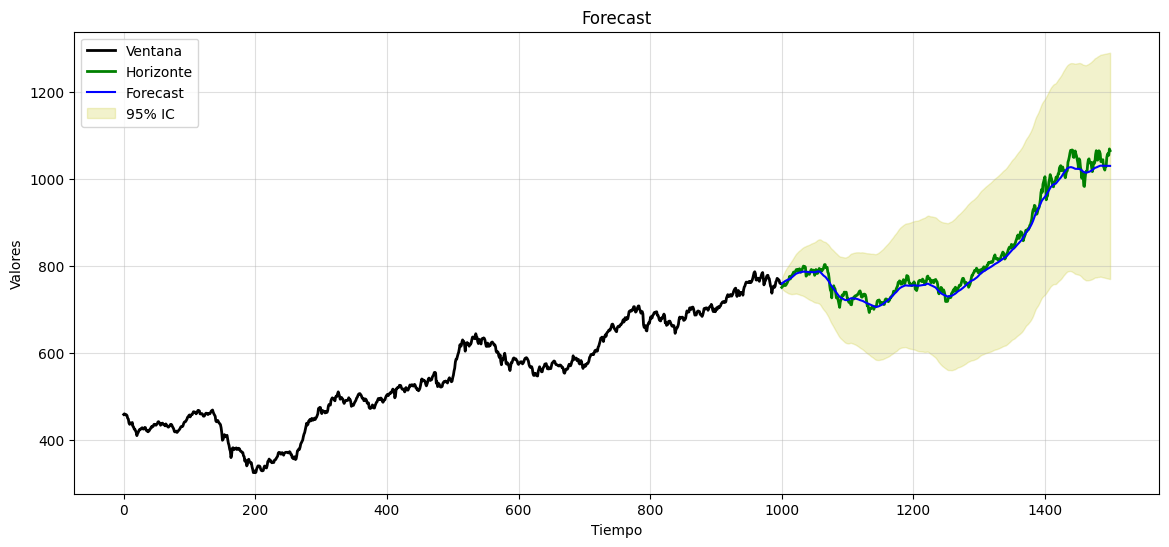

In [116]:
n_ventana = len(ventana)
n_horizonte = len(horizonte)
idx_ventana = np.arange(n_ventana)
idx_horizonte = np.arange(n_ventana, n_ventana + n_horizonte)

plt.figure(figsize=(14,6))
plt.plot(idx_ventana, ventana.values, label='Ventana', color='black', linewidth=2)
plt.plot(idx_horizonte, horizonte.values, label='Horizonte', color='green', linewidth=2)
plt.plot(idx_horizonte, forecast_reescalado, label='Forecast', color='b', linewidth=1.5)

plt.fill_between(intervalo.index, intervalo.iloc[:, 0], intervalo.iloc[:, 1],
                 color='y', alpha=0.2, label='95% IC')

plt.xlabel('Tiempo')
plt.ylabel('Valores')
plt.title('Forecast')
plt.legend()
plt.grid(alpha=0.4)
plt.show()